Table of content
---


##### PLANS
- make a list of ingredients to exclude (reduce features == improve efficiency?)

Import libraries
---

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

Read data
---

In [15]:
df = pd.read_csv('../data/cleaned_recipes.csv')
df.shape

(231635, 12)

In [3]:
df.head(0)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients


Feature engineering `minutes`
---
### How much time to spare?
When it comes to cooking, cooking times may vary. Because of the the variability, cooking time can sometimes hinder users from actually cooking what is recommended. For instance, a user who is looking for a quick lunch will certainly not cook the recommended *Chipotle Carne Guisada* that takes 2+ hours.

As a solution, I'm classifying cooking times, `minutes`, instead of leaving it as a continuous variable. This will improve the user experience by allowing users to pick a general duration of their time comitment instead of a specific duration in minutes.

Considering the following established tags,
```
'15-minutes-or-less',
'30-minutes-or-less',
'4-hours-or-less',
'60-minutes-or-less'
```
I'm classifying cooking times into the following time ranges. I disregarded recipes that are tagged '4-hours-or-less' because any recipes requiring more than an hour is probably only of interest to those who are more experienced in cooking and wouldn't mind the complexity and commitment. Hence, they would also don't mind cooking for 2, 4, even 12 hours. 

| Column Name     | Time Range |
|-----------------|------------|
| '15_or_less'    | 0 - 15     |
| '30_or_less'    | 0 - 30     |
| '60_or_less'    | 0 - 60     |
| 'doesnt_matter' | 0 - ∞      |

**Define a function to bin `minutes`**

In [16]:
def bin_cooking_time(new_col_name, max_t):
    """
    new_col_name = new column name
    max_t = maximum cooking time (in minutes)
    """
    
    df[new_col_name] = 0

    for i in range(len(df)):
        if df.loc[i, 'minutes'] <= max_t:
            df.loc[i, new_col_name] = 1
            
    return df

**Run the function**

In [ ]:
%%time

bin_cooking_time('30_or_less', 30)
bin_cooking_time('60_or_less', 60)
bin_cooking_time('120_or_less', 120)
bin_cooking_time("doesnt_matter", max(df.minutes))

df.shape

**Check the distribution of new `minutes` bins**

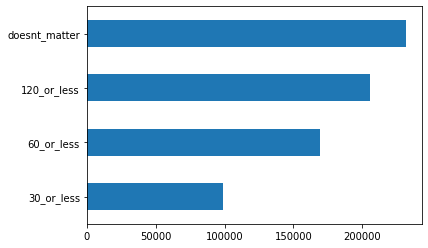

In [9]:
df[['30_or_less', '60_or_less', '120_or_less','doesnt_matter']].sum().sort_values().plot(kind='barh');

Feature engineering `tags`
---
The `tags` column is a string data. Usually, I utilize NLP tools to transform text data into vectors. However, I want to keep the tags unaltered if possible. Hence I'm converting them into lists first before I binarize them. This way, I'm able to avoid altering the original tags had I approached it like an NLP problem and stemmed or lemmatized the data. 

**Define a function that converts a `string` into `list`**

In [6]:
def make_lists(col):
    """
    col = name of column to convert into a list 
    """
    
    indices = list(df.index)
    for i in indices:
        df.at[i, col] = df.loc[i, col][2:-2].split("', '")
        
    return df[col]

**Convert `string` data into `list`**

In [11]:
%%time

make_lists('tags')

CPU times: user 3.75 s, sys: 98.4 ms, total: 3.85 s
Wall time: 3.85 s


0         [60-minutes-or-less, time-to-make, course, mai...
1         [30-minutes-or-less, time-to-make, course, mai...
2         [time-to-make, course, preparation, main-dish,...
3         [60-minutes-or-less, time-to-make, course, mai...
4         [weeknight, time-to-make, course, main-ingredi...
                                ...                        
231630    [ham, 60-minutes-or-less, time-to-make, course...
231631    [15-minutes-or-less, time-to-make, course, pre...
231632    [60-minutes-or-less, time-to-make, course, mai...
231633    [30-minutes-or-less, time-to-make, course, pre...
231634    [30-minutes-or-less, time-to-make, course, pre...
Name: tags, Length: 231635, dtype: object

Sanity check:

In [12]:
type(df['tags'][0])

list

**Vectorize `tags` using `MultiLabelBinarizer`**

In [13]:
tags_df = df['tags']
tags_df[:5]

0    [60-minutes-or-less, time-to-make, course, mai...
1    [30-minutes-or-less, time-to-make, course, mai...
2    [time-to-make, course, preparation, main-dish,...
3    [60-minutes-or-less, time-to-make, course, mai...
4    [weeknight, time-to-make, course, main-ingredi...
Name: tags, dtype: object

In [ ]:
ingred_df.str.join('|').str.get_dummies().add_prefix('ingredient_')

In [14]:
mlb = MultiLabelBinarizer()

tags_df = pd.DataFrame(mlb.fit_transform(tags_df), columns=mlb.classes_, index=tags_df.index)

tags_df.head()

,,1-day-or-more,15-minutes-or-less,3-steps-or-less,30-minutes-or-less,4-hours-or-less,5-ingredients-or-less,60-minutes-or-less,Throw the ultimate fiesta with this sopaipillas recipe from Food.com.,a1-sauce,...,whitefish,whole-chicken,whole-duck,whole-turkey,wild-game,wings,winter,yams-sweet-potatoes,yeast,zucchini
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are 552 unique tags from binarizing raw `tags` list. However, there's a bit of cleaning to handle tags that are alike but off by 1 letter, odd, or too generic like the following:
```
''
'simply-potatoes2'
'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.'
'crusts-pastry-dough-2'
'healthy-2'
'lasagna'
'lasagne'
'less_thansql:name_topics_of_recipegreater_than'
'rosh-hashana'
'rosh-hashanah'
'simply-potatoes'
'simply-potatoes2'
```

Firstly, I'm combining identical tags as one to minimize redundancy.

Secondly, I'm dropping `tags` with less than 50 and more than 70,000 recipes tagged with it. This ignores tags that appears too infrequent or too frequent, just as the `min_df` and `max_df` does in CountVectorizer. Too infrequent tags only have a few recipes to, while too frequent tags are too generic to be meaningful.

**Create a list for `tags` to drop called `drop_list`**

In [15]:
drop_list = ['']

**Combine identical tags**

In [18]:
for i in range(len(tags_only)):
    if tags_df.loc[i, 'healthy-2'] == 1:
        tags_df.loc[i, 'healthy'] = 1
        
drop_list.append('healthy-2')

len(drop_list)

CPU times: user 6.14 s, sys: 10.8 ms, total: 6.15 s
Wall time: 6.14 s


120

**Add `tags < 50` and `tags > 70,000` to `drop_list`**

In [16]:
for col in tags_df.columns:
    if tags_df[col].sum() < 50:
        drop_list.append(col)
        
len(drop_list)

108

In [17]:
for col in tags_df.columns:
    if tags_df[col].sum() > 70_000:
        drop_list.append(col)
        
len(drop_list)

119

**Drop unnecessary tags**

In [19]:
tags_df.drop(columns=drop_list, inplace=True)

(231635, 432)

Sanity Check:

In [20]:
tags_df.head(0)

,1-day-or-more,15-minutes-or-less,3-steps-or-less,30-minutes-or-less,4-hours-or-less,5-ingredients-or-less,60-minutes-or-less,african,american,amish-mennonite,...,white-rice,whitefish,whole-chicken,whole-turkey,wild-game,wings,winter,yams-sweet-potatoes,yeast,zucchini


**Concatenate binarized tags to the complete DataFrame**

In [21]:
df = pd.concat([df, tags_df], axis=1)
# df = df.drop(columns = 'tags')

In [22]:
df.shape

(231635, 448)

Feature engineering `ingredients`
---
### What do I want to cook with?


In [7]:
%%time

make_lists('ingredients')

CPU times: user 4.2 s, sys: 134 ms, total: 4.34 s
Wall time: 4.53 s


0         [winter squash, mexican seasoning, mixed spice...
1         [prepared pizza crust, sausage patty, eggs, mi...
2         [ground beef, yellow onions, diced tomatoes, t...
3         [spreadable cheese with garlic and herbs, new ...
4         [tomato juice, apple cider vinegar, sugar, sal...
                                ...                        
231630    [celery, onion, green sweet pepper, garlic clo...
231631    [paprika, salt, garlic powder, onion powder, d...
231632    [hard-cooked eggs, mayonnaise, dijon mustard, ...
231633    [butter, eagle brand condensed milk, light bro...
231634    [granulated sugar, shortening, eggs, flour, cr...
Name: ingredients, Length: 231635, dtype: object

In [11]:
ingred_df = df['ingredients'].head(20)
ingred_df.head(3)

0    [winter squash, mexican seasoning, mixed spice...
1    [prepared pizza crust, sausage patty, eggs, mi...
2    [ground beef, yellow onions, diced tomatoes, t...
Name: ingredients, dtype: object

In [12]:
ingred_df.str.join('|').str.get_dummies().add_prefix('ingredient_')

,ingredient_a.1. original sauce,ingredient_apple,ingredient_apple cider vinegar,ingredient_bacon,ingredient_baking soda,ingredient_bananas,ingredient_beef broth,ingredient_black pepper,ingredient_broccoli floret,ingredient_brown sugar,...,ingredient_whipping cream,ingredient_whiskey,ingredient_white vinegar,ingredient_whole berry cranberry sauce,ingredient_whole green chilies,ingredient_winter squash,ingredient_wood bethony,ingredient_yellow bell pepper,ingredient_yellow onion,ingredient_yellow onions
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
8,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd.get_dummies(ingred_df.apply(pd.Series).stack()).sum(level=0)

In [78]:
pd.DataFrame(mlb.fit_transform(ingred_df), columns=mlb.classes_, index=ingred_df.index)


,1% fat buttermilk,1% fat cottage cheese,1% low-fat chocolate milk,1% low-fat milk,"1% low-fat milk', ""confectioners' sugar",10 bean soup mix,10 inch low-fat flour tortillas,"10"" pie crust",10% cream,10-inch deep dish pie crust,...,ziti rigati,zoom quick hot cereal,zucchini,zucchini with italian-style tomato sauce,"zucchini', ""campbell's cream of mushroom soup"", 'sour cream","zucchini', ""confectioners' sugar"", 'fresh lemon juice","zucchini', ""confectioners' sugar"", 'milk","zucchini', ""uncle ben's converted brand rice"", 'low-fat cheese",zwieback toast,zwieback toast crumbs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
cvec = CountVectorizer(min_df=.01, max_df=.8, ngram_range=(1,5))

In [53]:
ingredients_cvec = cvec.fit_transform(ingredients['ingredients'])

In [54]:
list(cvec.get_feature_names())

['all',
 'all purpose',
 'all purpose flour',
 'all purpose flour baking',
 'all purpose flour baking powder',
 'allspice',
 'almond',
 'almonds',
 'and',
 'and half',
 'and pepper',
 'apple',
 'apples',
 'baby',
 'bacon',
 'baking',
 'baking powder',
 'baking powder baking',
 'baking powder baking soda',
 'baking powder baking soda salt',
 'baking powder salt',
 'baking soda',
 'baking soda salt',
 'balsamic',
 'balsamic vinegar',
 'banana',
 'bananas',
 'basil',
 'bay',
 'bay leaf',
 'bay leaves',
 'beans',
 'beef',
 'beef broth',
 'beef onion',
 'bell',
 'bell pepper',
 'bell peppers',
 'black',
 'black beans',
 'black pepper',
 'blueberries',
 'boiling',
 'boiling water',
 'boneless',
 'boneless skinless',
 'boneless skinless chicken',
 'boneless skinless chicken breast',
 'boneless skinless chicken breasts',
 'bouillon',
 'bread',
 'breadcrumbs',
 'breast',
 'breast halves',
 'breasts',
 'broccoli',
 'broth',
 'brown',
 'brown sugar',
 'butter',
 'butter flour',
 'butter onion',
 

In [44]:
ingredients_df = pd.DataFrame(ingredients_cvec.toarray(), columns=cvec.get_feature_names())
ingredients_df.head()

,10,100,10x,12,15,151,18,21,35,43,...,yve,za,zatarain,zest,zesty,zinfandel,ziploc,ziti,zucchini,zwieback
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
list(ingredients.columns)

```
1% fat
10-inch
9 in.
9" pastry
96% lean ground beef
'agave nectar\', "confectioners\' sugar", \'vanilla extract',
'all-purpose flour\', "confectioners\' sugar", \'milk',
```